In [2]:
from tonic.datasets.nmnist import NMNIST
from torch import nn
from torch.nn import functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import math
import numpy as np

root_dir = './nmnist'
_ = NMNIST(save_to=root_dir, train=True)
_ = NMNIST(save_to=root_dir, train=False)

In [3]:
from tonic.transforms import ToFrame
from tonic.datasets import nmnist

batch_size = 4
num_workers = 4
device = "cuda:0"
shuffle = True

# Transform that accumulates events into single frame image
to_frame = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=1)

train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_frame)
test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_frame)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)

In [4]:
model_linear = nn.Sequential(
    # [2, 34, 34] -> [10]
    nn.Linear(2 * 34 * 34, 10),
    nn.ReLU(),
)

In [5]:
model_conv_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [6]:
model_conv_avg_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [7]:
model_sinabs = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    
    # [8, 17, 17] -> [16, 8, 8]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    
    # [16, 8, 8] -> [16, 4, 4]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size = (3,3), padding=(1,1), stride=(2,2), bias=False),
    nn.ReLU(),
    
    # [16 * 4 * 4] -> [10]
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 10, bias=False),
    nn.ReLU()
)

In [8]:
model = model_sinabs
model.load_state_dict(torch.load("./weights/model-weights.pth"))

/tmp/ipykernel_2202997/3734851863.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./weights/model-weights.pth"))


<All keys matched successfully>

In [9]:
from sinabs.from_torch import from_model
import sinabs.activation.spike_generation as spikegen

snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model
snn

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=10, bias=False)
  (10): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Pa

In [10]:
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

snn = snn.to(device)

In [11]:
sample_data, label = snn_test_dataset[0]
print(sample_data.shape)
sample_data = torch.tensor(sample_data).reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
logits = snn(sample_data).reshape(1, 100, -1)
output = logits.sum(dim=1)
pred = output.argmax(dim=1, keepdim=True)
print(pred)

(100, 2, 34, 34)
tensor([[0]], device='cuda:0')


In [12]:
_ = snn.to('cpu')
zeros = torch.zeros(sample_data.shape)
ones = torch.ones(sample_data.shape)

In [13]:
modules = list(snn.modules())[1:]
print(f'spike_threshold: {float(modules[1].spike_threshold)}\nmin_v_mem: {float(modules[1].min_v_mem)}')

spike_threshold: 1.0
min_v_mem: -1.0


In [14]:
conv = modules[0]
conv_out = conv(ones)
iaf = modules[1]
iaf_out = iaf(conv_out)

print(torch.min(conv_out), torch.max(conv_out))

tensor(-1.3294, grad_fn=<MinBackward1>) tensor(3.9885, grad_fn=<MaxBackward1>)


In [15]:
W = list(conv.parameters())[0]
W.shape
conv_out.shape

torch.Size([100, 8, 34, 34])

In [16]:
def plot_tensor(tensor, ax, printcb=False):
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be a 2D tensor.")
    
    tensor_np = tensor.numpy()  # Convert to numpy array
    ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')

    cax = ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')
    if printcb:
        fig.colorbar(cax, ax=ax)  # Show color scale
    ax.axis('off')


In [17]:
def get_class_name(class_string):
    # Strip the angle brackets and split the string by dots
    split_string = class_string.strip("<>").split(".")
    # Get the last element from the split string
    class_name = split_string[-1]
    # Remove the ending single quote if it exists
    return class_name.strip("'")

torch.Size([1, 5, 30, 100])


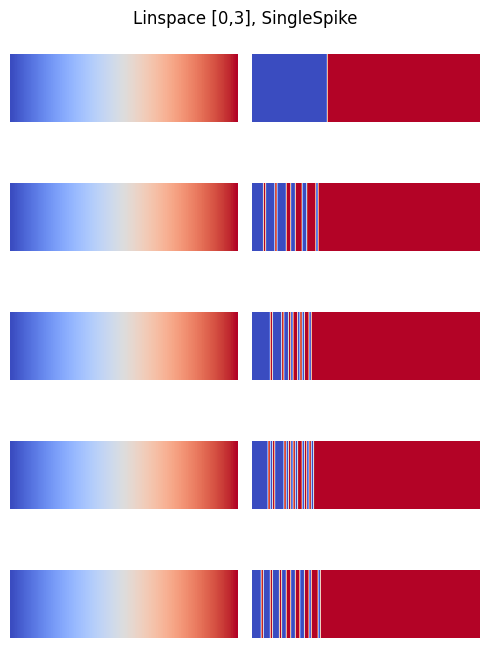

In [18]:
from sinabs.layers import IAF,LIF

import numpy as np

#tensor = torch.rand((1, 2, 34, 34))
#tensor[0,1] = tensor[0,0]
begin = 0
end = 3
tensor = torch.linspace(begin, end, steps=100).repeat(30, 1)
iaf = IAF(spike_fn = spikegen.SingleSpike, record_states=True)

t = 5

image = tensor.unsqueeze(0)
image = torch.stack([image] * t, dim=1)

title = f'Linspace [{begin},{end}], {get_class_name(str(iaf.spike_fn))}'

# image[0, 1:3] = torch.zeros((30, 100))
# image[0, 3] = torch.zeros((30, 100))
# title += ', with interruptions'
#image = sample_data[10].unsqueeze(0).cpu()
print(image.shape)
fig, ax = plt.subplots(image.shape[1], 2, figsize=(5,7))
for i in range(image.shape[1]):
    with torch.no_grad():
        plot_tensor(image[0,i], ax[i,0])
        plot_tensor(iaf(image)[0,i], ax[i, 1])


plt.tight_layout()
fig.suptitle(title)
plt.show()


In [19]:
recordings = iaf.recordings['v_mem']
x = 30
y = 0
print(recordings.shape)
print(image[0, 0, y, x])
for i in range(recordings.shape[1]):
    print(f'{float(image[0,i,y,x]):.4f} -> {float(recordings[0,i,y,x]):.4f}')


torch.Size([1, 5, 30, 100])
tensor(0.9091)
0.9091 -> 0.0909
0.9091 -> 0.0000
0.9091 -> 0.9091
0.9091 -> 0.8182
0.9091 -> 0.7273


In [20]:
def conv_layer(x: 'np.ndarray[np.float32]', W):
    C_in = W.shape[1]
    C_out = W.shape[0]
    kernel_size = tuple((W.shape[2:4]))
    stride = 1
    padding = (1,1)
    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding[0],
                              x.shape[2] + 2*padding[0])
    data_padded[:, padding[0]:x.shape[1] + padding[0], padding[1]:x.shape[2] + padding[1]] = x.cpu()
    output = torch.zeros(C_out, x.shape[1], x.shape[2])
    
    coordinate_pairs = [(a, b) for a in range(0, x.shape[1], stride) for b in range(0, x.shape[2], stride)]
    for l in range(C_out):
        for k in range(C_in):
            kernel = W[l,k]
            for i, j in coordinate_pairs:
                i_pad = i + padding[0]
                j_pad = j + padding[1]
                for m_ in range(kernel_size[0]):
                    m = m_ - 1
                    for n_ in range(kernel_size[1]):
                        n = n_ -1
                        output[l, i, j] += (kernel[m_, n_]
                                            * data_padded[k, i_pad + m, j_pad + n])

    return output


x = torch.ones([2, 34, 34])
# sample_data.to('cpu')
# x = sample_data[0].to('cpu')
conv_theirs = conv(x)
conv_mine = conv_layer(x, W)



In [21]:
precision = 5
mine_round = torch.round(conv_mine * 10**precision) / 10**precision
theirs_round = torch.round(conv_theirs * 10**precision) / 10**precision
num_true = torch.sum(mine_round == theirs_round).item()
num_false = (mine_round==theirs_round).numel() - num_true
print(f'True: {num_true}, False: {num_false}')
false_indexes = torch.nonzero((conv_mine == conv_theirs) == False, as_tuple=False)
print(conv_theirs[0,0,0])
print(conv_mine[0,0,0])


True: 9248, False: 0
tensor(-0.5376, grad_fn=<SelectBackward0>)
tensor(-0.5376, grad_fn=<SelectBackward0>)


In [22]:
weights_np = W.detach().numpy() 
theirs_np = conv_theirs.detach().numpy()
mine_np = conv_mine.detach().numpy()

In [23]:
conv_mine.reshape(1, 1, 8, 34, 34).shape


torch.Size([1, 1, 8, 34, 34])

In [24]:
class if_layer:
    def __init__(self, input_shape):
        self.membrane = torch.zeros(input_shape)
        self.coordinate_pairs = [(a, b) for a in range(input_shape[1]) for b in range(input_shape[2])]
        self.v_th = 1.0
        
    def reset(self):
        self.membrane = torch.zeros(input_shape)
    def __call__(self, x: 'np.ndarray[np.float32]'):
        '''Basic implementation of IF layer.
        Assumptions:
        spike_threshold = 1.0,
        spike_fn = SingleSpike
        No batch, No timing: the FPGA simply runs everything on FIFO basis
        Thererofe, this has to be a class.
        x dimensions: [c, y, x]
        '''
        output = torch.zeros(self.membrane.shape)
        for c in range(x.shape[0]):
            for (i, j) in self.coordinate_pairs:
                self.membrane[c, i, j] +=  x[c, i, j]

                if self.membrane[c, i, j] > self.v_th:
                    output[c,i,j] = 1;
                    self.membrane[c, i, j] -= 1

        return output


In [25]:
class if1_layer:
    def __init__(self, input_shape):
        self.elems = torch.tensor(input_shape).prod().item()
        self.membrane = torch.zeros([self.elems])
        self.coordinate_pairs = [(a, b) for a in range(input_shape[1]) for b in range(input_shape[2])]
        self.v_th = 1.0
        
    def reset(self):
        self.membrane = torch.zeros(input_shape)
    def __call__(self, x: 'np.ndarray[np.float32]'):
        '''Basic implementation of IF layer.
        Assumptions:
        spike_threshold = 1.0,
        spike_fn = SingleSpike
        No batch, No timing: the FPGA simply runs everything on FIFO basis
        Thererofe, this has to be a class.
        x dimensions: [c, y, x]
        '''
        input_shape = x.shape
        x = x.reshape((self.elems,))
        output = torch.zeros(self.elems)
        for e in range(self.elems):
            self.membrane[e] +=  x[e]
            if self.membrane[e] > self.v_th:
                output[e] = 1;
                self.membrane[e] -= 1

        output = output.reshape(input_shape)
        return output

In [26]:
if_torch_np = ifs_theirs[0].detach().numpy()
np.save('./tensors/if-torch.npy', if_torch_np)

NameError: name 'ifs_theirs' is not defined

In [27]:
lel = modules[1](modules[0](torch.ones([2, 34, 34]))
           )


In [28]:
def avg_pool2d(x):
    kernel = (2,2)
    stride = 2
    padding = 0

    # Create output buffer
    H_out = math.floor((x.shape[1] + (2 * padding) - kernel[0]) / stride) + 1
    W_out = math.floor((x.shape[2] + (2 * padding) - kernel[0]) / stride) + 1
    output = torch.zeros((x.shape[0], H_out, W_out))

    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding,
                              x.shape[2] + 2*padding)
    data_padded[:, padding:x.shape[1] + padding, padding:x.shape[2] + padding] = x.cpu()

    coordinate_pairs = [(a, b) for a in range(H_out) for b in range(W_out)]
    coordinate_pairs.sort()
    kernel_pairs = [(a, b) for a in range(kernel[0]) for b in range(kernel[1])]
    kernel_pairs.sort()
    for c in range(output.shape[0]):
        for (h, w) in coordinate_pairs:
            # Apply kernel
            kernel_sum = 0
            for (m, n) in kernel_pairs:
                kernel_sum += data_padded[c, stride * h + m, stride * w + n]
            output[c, h, w] = 1 / (kernel[0] * kernel[1]) * kernel_sum

    return output                         

In [29]:
x = ifs_mine[0]
pool = nn.AvgPool2d(2, 2)

pool_mine = avg_pool2d(x)
pool_torch = pool(x.unsqueeze(0))

precision = 5
mine_round = torch.round(pool_mine * 10**precision) / 10**precision
torch_round = torch.round(pool_torch * 10**precision) / 10**precision
num_true = torch.sum(mine_round == torch_round).item()
num_false = (mine_round==torch_round).numel() - num_true
print(f'True: {num_true}, False: {num_false}')
#false_indexes = torch.nonzero((pool_mine == pool_torch) == False, as_tuple=False)


NameError: name 'ifs_mine' is not defined

In [30]:
pool_torch_np = pool_torch.detach().numpy()
pool_mine_np = pool_mine.detach().numpy()

np.save('./tensors/pool-torch.npy', pool_torch_np)
np.save('./tensors/pool-mine.npy', pool_mine_np)

NameError: name 'pool_torch' is not defined

In [31]:
x = sample_data.cpu()
saved_x = x.detach().numpy()
np.save('./tensors/sample-data.npy', saved_x)
saved_x.shape

(100, 2, 34, 34)

In [32]:
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
with torch.no_grad():
    saved_output = snn(x.squeeze(0))

np.save('./tensors/output.npy', saved_output)
saved_output.shape

torch.Size([100, 10])

In [33]:
def get_module_name(input_string):
    input_string = str(input_string)
    # Pattern to match the function name and contents within first
    pattern = r"^([a-zA-Z_][a-zA-Z0-9_]*)\(.*"
    
    match = re.match(pattern, input_string)
    if match:
        return match.group(1)  # Return the function name
    else:
        return None  # If there's no match

In [92]:
import re
import os
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
mods = list(snn.modules())[1:]
outs = list()
mems = list()

data = torch.tensor(np.load(f"tensors/datafile.npy"))

with torch.no_grad():
    end_of_data = False
    count = 0
    while not end_of_data:
        if not os.path.isfile(f"tensors/x{count}.npy"):
            end_of_data = True
            break

        mod = mods[count % len(mods)]
        mod_name = get_module_name(mod)

        if count % len(mods) == 0:
            print(f'\n====== BEGIN ITERATION {count // len(mods)} ======')
            batch = count // len(mods)
            x = data[0].unsqueeze(0)

        if (mod_name == 'IAFSqueeze'):
            mod.record_states = True

        # Get the data
        x_hat = torch.tensor(np.load(f"tensors/x{count}.npy"))
        x = mod(x)

        correctness = torch.unique(torch.isclose(x, x_hat, atol=1e-5))
        if len(correctness) != 1:
            print(f'Failed at {mod_name}')
            break
        
        if (mod_name == 'IAFSqueeze'):
            recordings = mod.recordings['v_mem']
            recordings_hat = torch.tensor(np.load(f"tensors/membrane{count}.npy")).reshape(recordings.shape)

            mem_correct = torch.isclose(recordings_hat, recordings, atol=1e-5)
            print(f'IAF[{count % len(mods)}] Unique non-zero recordings: {len(torch.unique(recordings))-1}')
            if torch.unique(mem_correct) != 1:
                print(f'Failed at {mod_name} - Membrane mismatch')
                wrong_idx = torch.where(mem_correct == False)
                wrong_i = 1
                ex_pos = (int(wrong_idx[0][wrong_i]), int(wrong_idx[1][wrong_i]),
                          int(wrong_idx[2][wrong_i]), int(wrong_idx[3][wrong_i]),
                          int(wrong_idx[4][wrong_i]))
                print(f'Example: {ex_pos}: {recordings[ex_pos]} != {recordings_hat[ex_pos[2:]]}')

        if (mod_name == 'Conv2D'):
            

        
        count += 1
    print(f'\nStopped: count {count}')



====== BEGIN ITERATION 0 ======
IAF[1] Unique non-zero recordings: 72
IAF[4] Unique non-zero recordings: 0
IAF[7] Unique non-zero recordings: 0
IAF[10] Unique non-zero recordings: 0

====== BEGIN ITERATION 1 ======
IAF[1] Unique non-zero recordings: 72
IAF[4] Unique non-zero recordings: 316
IAF[7] Unique non-zero recordings: 0
IAF[10] Unique non-zero recordings: 0

====== BEGIN ITERATION 2 ======
IAF[1] Unique non-zero recordings: 72
IAF[4] Unique non-zero recordings: 304
Failed at Conv2d

Stopped: count 28


In [35]:
lnum = 1
py = np.array(outs[lnum-1]).squeeze(0)
me = np.load(f'./tensors/layer{lnum}.npy')
print(f'py: {py.shape}, me: {me.shape}')
print(np.unique((py == me)))
print((py - me).mean())
idx = np.where(py != me)
print(len(idx[0]))


NameError: name 'outs' is not defined

In [36]:
i = 567
yes = (idx[0][i], idx[1][i], idx[2][i])
print(yes)
print(py[yes])
print(me[yes])

NameError: name 'idx' is not defined

In [37]:
import sinabs
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
data = torch.tensor(np.load("./tensors/layer0.npy"))
x = data.clone()

#iaf = list(snn.modules())[2]
iaf = sinabs.layers.IAF(spike_fn=spikegen.SingleSpike)
#iaf = if1_layer(x.shape)
iaf.record_states = True
l = 5

y_hat = torch.tensor(np.load(f"./tensors/layer{l}.npy"))
y = 0
loc = (0,0,0)
mem = 0
for i in range(l):
    x = data.clone()
    y = iaf(x)
    print(f"{mem:.6f} + {x[loc]:.6f} = {iaf.recordings['v_mem'][loc]:.6f}, fired? {y[loc]}")
    #print(f"{mem:.6f} + {x[loc]:.6f} = {iaf.membrane[0]:.6f}, fired? {y[loc]}")
    mem = iaf.recordings['v_mem'][loc].clone()
    # if i == 1:
    #     x = torch.zeros((2,34,34))

print(y.sum(), y_hat.sum())


FileNotFoundError: [Errno 2] No such file or directory: './tensors/layer0.npy'

In [38]:
np.where(np.isclose(x, 0.395, atol=1e-1))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [39]:
x = torch.tensor(np.load("./tensors/layer0.npy"))
print(np.where(np.isclose(x, 0.6512748599052429, atol=1e-2)))
x[1,1,1]

FileNotFoundError: [Errno 2] No such file or directory: './tensors/layer0.npy'